In [1]:
import torch
import torch.nn as nn
import numpy as np

from model import RecEnvSimModel
from data_loader import PongDataLoader

In [2]:
train_data_loader = PongDataLoader('dataset40.zip')
test_data_loader = PongDataLoader('dataset10.zip')

# get shapes
dim1 , dim2 = train_data_loader.first_dim , train_data_loader.second_dim
print('image shape is ',(dim1,dim2))

image shape is  (64, 80)


In [3]:
LSTM_config = (32*2*3,
               100,
               3,
               200)

encoder_config = (1, # in_channels
                  [64,32,32,32], # num_filters_list 
                  [(8,8),(6,6),(6,6),(4,4)], # filter_size_list
                  [2 for _ in range(4)], # stride_list
                  [(1,1),(1,1),(1,1),(0,0)]) # padding_list

decoder_config = (100, # input_length
                  [32,2,3], # deconv_input_shape
                  [32,32,64,1], # num_filters_list 
                  [(4,4),(6,6),(6,6),(8,8)], # filter_size_list
                  [2 for _ in range(4)], # stride_list
                  [(0,0),(1,1),(1,1),(1,1)]) # padding_list


In [4]:
model = RecEnvSimModel(LSTM_config, encoder_config, decoder_config)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
temp_states, temp_actions = train_data_loader.get_data(1,15)
states_tensor = torch.Tensor(temp_states) # of shape (1,16,dim1,dim2)
actions_tensor = nn.functional.one_hot(torch.Tensor(temp_actions.astype(int)).long(),num_classes=3) # if I don't put the long() method, one_hot won't work
# actions_tensor = torch.transpose(actions_tensor,-1,-2).float() # swap dimensions -1 and -2
actions_tensor = actions_tensor[:,:,:,None].float()

# actions_tensor is of shape (1,16,3)
init_hidden = torch.zeros([1,100])
init_cell = torch.zeros([1,100])
out, hc = model(states_tensor[0:1,0:1,:,:], actions_tensor[0:1,0,:,:], (init_hidden,init_cell))

c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [6]:
print(hc[0].shape)
print(hc[1].shape)
print(states_tensor[0:1,0:1,:,:].shape)
print(out.shape)

torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([1, 1, 64, 80])
torch.Size([1, 1, 64, 80])


In [5]:
n_training_steps = 1000
SEQ_LENGTH = 15
BATCH_SIZE = 16

for train_step in range(n_training_steps):
    if train_step%1==0: print('Train step',train_step)
    train_loss = 0.0
    states, actions = train_data_loader.get_data(BATCH_SIZE,SEQ_LENGTH)
    states_tensor = torch.Tensor(states) # of shape (BATCH_SIZE,SEQ_LENGTH+1,dim1,dim2)
    actions_tensor = nn.functional.one_hot(torch.Tensor(actions.astype(int)).long(),num_classes=3) # if I don't put the long() method, one_hot won't work
    actions_tensor = actions_tensor[:,:,:,None].float()
    output_tensor = torch.zeros((BATCH_SIZE,SEQ_LENGTH,dim1,dim2))

    optimizer.zero_grad()
    h = torch.zeros([1,100])
    c = torch.zeros([1,100])
    for i in range(SEQ_LENGTH):
        out,(h,c) = model(states_tensor[:,i:i+1,:,:],
                          actions_tensor[:,i,:,:],
                          (h,c))
        output_tensor[:,i:i+1,:,:] = out
        pass
    loss = criterion(output_tensor,states_tensor[:,1:,:,:])
    loss.backward()
    optimizer.step()


Train step 0


c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train step 1
Train step 2
Train step 3
Train step 4
Train step 5
Train step 6
Train step 7
Train step 8
Train step 9
Train step 10
Train step 11
Train step 12
Train step 13
Train step 14
Train step 15
Train step 16
Train step 17
Train step 18
Train step 19
Train step 20
Train step 21
Train step 22
Train step 23
Train step 24
Train step 25
Train step 26
Train step 27
Train step 28
Train step 29
Train step 30
Train step 31
Train step 32
Train step 33
Train step 34
Train step 35
Train step 36
Train step 37
Train step 38
Train step 39
Train step 40
Train step 41
Train step 42
Train step 43
Train step 44
Train step 45
Train step 46
Train step 47
Train step 48
Train step 49
Train step 50
Train step 51
Train step 52
Train step 53
Train step 54
Train step 55
Train step 56
Train step 57
Train step 58
Train step 59
Train step 60
Train step 61
Train step 62
Train step 63
Train step 64
Train step 65
Train step 66
Train step 67
Train step 68
Train step 69
Train step 70
Train step 71
Train step 72
T

In [22]:
actions.shape

(16, 16)

frame  1 :


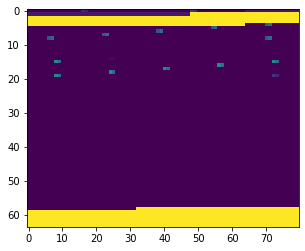

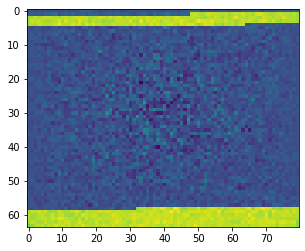

frame  2 :


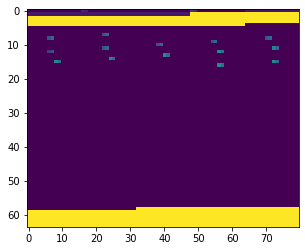

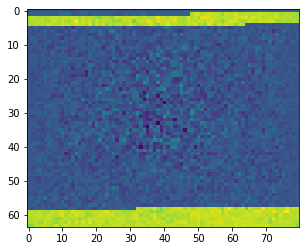

frame  3 :


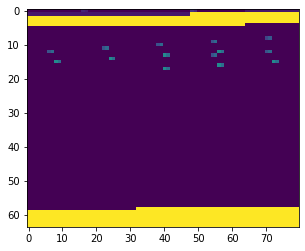

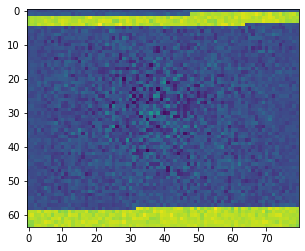

frame  4 :


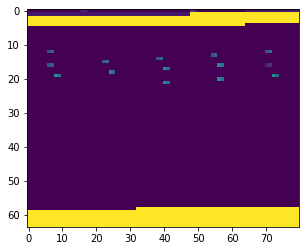

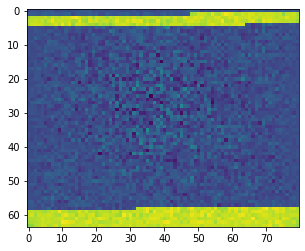

frame  5 :


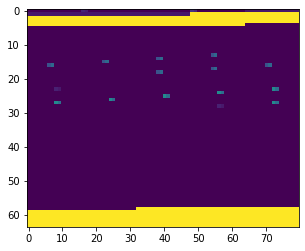

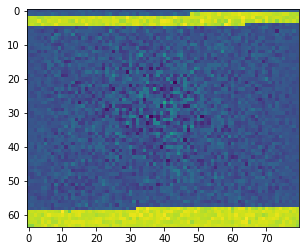

frame  6 :


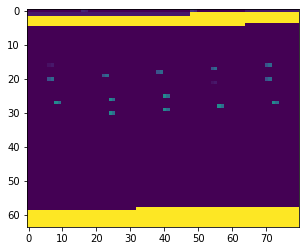

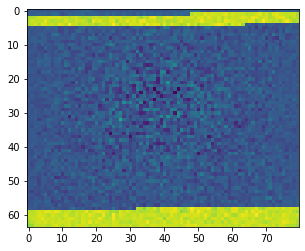

frame  7 :


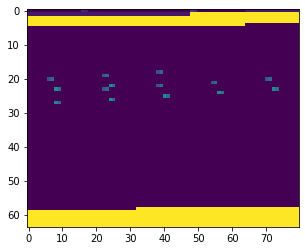

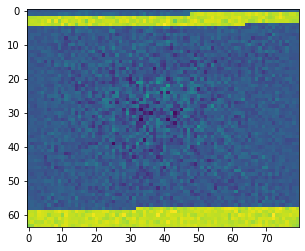

frame  8 :


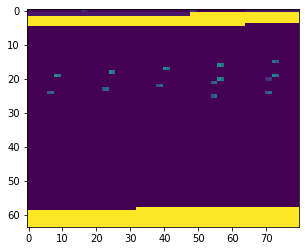

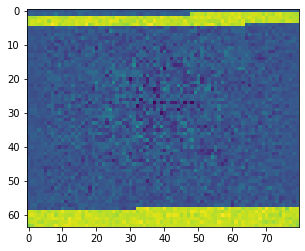

frame  9 :


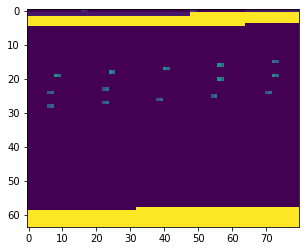

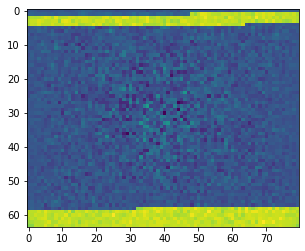

frame  10 :


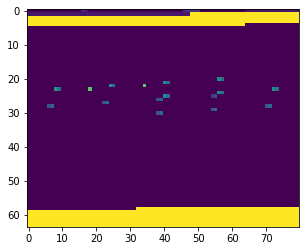

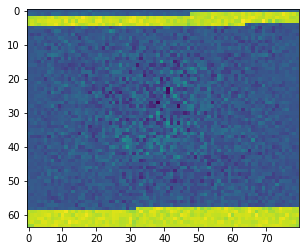

frame  11 :


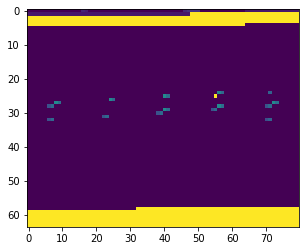

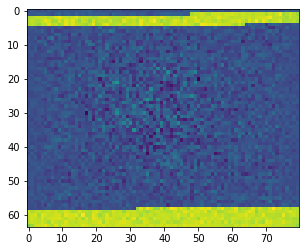

frame  12 :


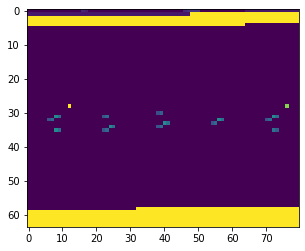

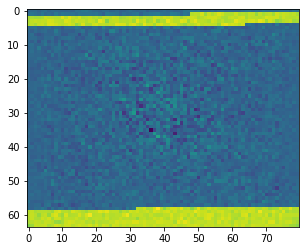

frame  13 :


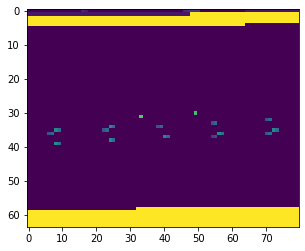

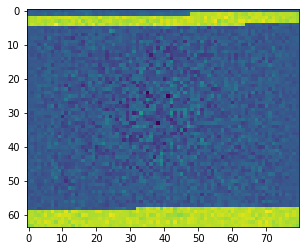

frame  14 :


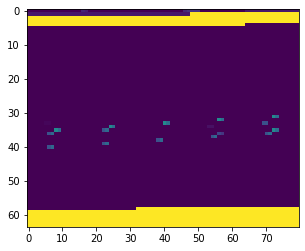

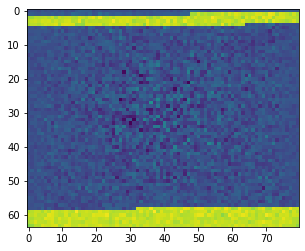

frame  15 :


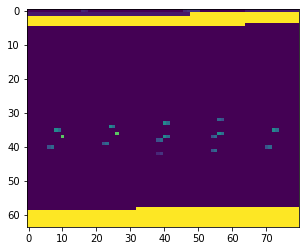

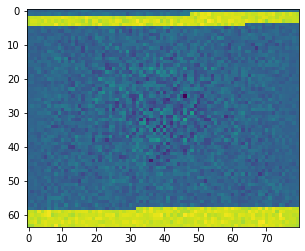

In [7]:
import matplotlib.pyplot as plt

with torch.no_grad():
    temp_states, temp_actions = test_data_loader.get_data(1,15)
    states_tensor = torch.Tensor(temp_states) # of shape (1,16,dim1,dim2)
    actions_tensor = nn.functional.one_hot(torch.Tensor(temp_actions.astype(int)).long(),num_classes=3) # if I don't put the long() method, one_hot won't work
    # actions_tensor = torch.transpose(actions_tensor,-1,-2).float() # swap dimensions -1 and -2
    actions_tensor = actions_tensor[:,:,:,None].float()

    # actions_tensor is of shape (1,16,3)
    output_tensor = torch.zeros((1,SEQ_LENGTH,dim1,dim2))
    h = torch.zeros([1,100])
    c = torch.zeros([1,100])
    for i in range(SEQ_LENGTH):
        out,(h,c) = model(states_tensor[:,i:i+1,:,:],
                          actions_tensor[:,i,:,:],
                          (h,c))
        output_tensor[:,i:i+1,:,:] = out
    output_images = output_tensor.numpy()[:,:,:,:]

    for i in range(SEQ_LENGTH):
        print('frame ',i+1,':')
        plt.imshow(temp_states[0,i+1,:,:])
        plt.show()
        plt.imshow(output_images[0,i,:,:])
        plt.show()
    
    